#### Example API and Analysis Notebook

In [3]:
from git import Repo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json

Repo.clone_from("https://github.com/costquestassociates/cqazapi-pytools.git", "cqazapipytools")
!pip install -r cqazapipytools/requirements.txt

In [4]:
API_KEY = ""

if not API_KEY:
    try:
        with open('secrets.json', 'r') as f:
            secrets = json.load(f)
        API_KEY = secrets.get('fabric_api_key')
    except FileNotFoundError:
        API_KEY = None

if not API_KEY:
    raise RuntimeError("API key not found. Please fill in your API_KEY in the variable above.")

# Example 1: Fiber Coverage by Greenfield Cost to Build

### Use API to query Clarke County, Georgia

In [ ]:
from cqazapipytools import *

VINTAGE = '202412'
FIELDS = 'location_id,blockfips,bdc_fiber,fibergreenfieldpassinv'
COUNTY_FIPS = '13058' # Clarke County, Georgia
CHUNK_SIZE = 1000
LIMIT = None  # None returns all rows

with cqazapipytools(API_KEY, cachepath='cache.db') as cp:
    # Collect Fabric UUIDs inside the county
    county_geojson = cp.apiAction(f'geosvc/libgetgeo/tiger/2020/counties?id={COUNTY_FIPS}', 'GET')
    uuids = cp.collect(VINTAGE, county_geojson)

    if LIMIT:
        uuids = uuids[:LIMIT]

    # Call Fabric bulk api, retrieve only desired fields
    endpoint = f'fabric/{VINTAGE}/bulk/locations?field={FIELDS}'
    results = cp.bulkApiAction(endpoint, 'POST', uuids, maxsize=CHUNK_SIZE)

    # Write to CSV 
    cp.csvWrite(f'county_{COUNTY_FIPS}_fabric.csv', results)

    # Show a quick sample
    print(f"Returned {len(results)} records")
    for r in results[:3]:
        print(r)

In [ ]:
results_df = pd.DataFrame(results)
results_df.drop('uuid', axis=1, inplace = True)
service_map = {3: "Unserved", 2: "Underserved", 1: "Served"}
results_df["service_level"] = results_df["bdc_fiber"].map(service_map).astype("category")
results_df.head()

### Quick Plotting

In [ ]:
df = results_df.copy()

min_val = df['fibergreenfieldpassinv'].min()
max_val = 5000
bins = np.arange(0, max_val + 1, 500)

# Create a bin label column (intervals)
df['inv_bin'] = pd.cut(df['fibergreenfieldpassinv'], bins=bins, include_lowest=True)

# Group and count by bin and service level
grouped = df.groupby(['inv_bin', 'service_level'], observed=True).size().unstack(fill_value=0)

# #Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
grouped.plot(kind='bar', stacked=True, ax=ax, width=0.8, colormap='tab20')

ax.set_xlabel('Fiber Greenfield Pass Investment (binned)', fontsize = 20)
ax.set_ylabel('BSL Count', fontsize = 20)
ax.set_title('Clarke County (Georgia) Fiber', fontsize = 20)
ax.legend(title='Service Level')

# Improve xlabels: show bin ranges nicely
ax.set_xticklabels([f'{np.abs(interval.left):.0f}–{interval.right:.0f}' for interval in grouped.index], rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Example 2: Competitive Provider Analysis

`SELECT DISTINCT SUBSTR(BlockFIPS, 1, 11)
  FROM read_parquet('*.parquet')
  WHERE City = 'BROOKHAVEN'
    AND State = 'GA';`

- Number of locations served by each Fiber provider (share of the market)
- Identify areas with few fiber providers (cheap to build), as potential opportunities
- Follium maps

In [89]:
from cqazapipytools import *

Brookhaven_tractFIPS = [
    '13089021101',
    '13089021103',
    '13089021104',
    '13089021219',
    '13089021220',
    '13089021221',
    '13089021222',
    '13089021405',
    '13089021410',
    '13089021411',
    '13089021412',
    '13089021415',
    '13089021416',
    '13089021417',
    '13089021418',
    '13089021419',
    '13089021420',
    '13089021421',
    '13089021607',
    '13121009409',
    '13121009410',
    '13121009607',
    '13121010115',
]

VINTAGE = '202412'
FIELDS = 'location_id,latitude,longitude,blockfips,bdc_fiber,bdc_fiberproviders'
CHUNK_SIZE = 1000

with cqazapipytools(API_KEY, cachepath='cache.db') as cp:
    tract_geojson = cp.apiAction(f'geosvc/libgetgeo/tiger/2020/tracts?id={Brookhaven_tractFIPS[0]}', 'GET')
    uuids = cp.collect(VINTAGE, tract_geojson)
    for fips in Brookhaven_tractFIPS[1:]:
        tract_geojson = cp.apiAction(f'geosvc/libgetgeo/tiger/2020/tracts?id={fips}', 'GET')
        uuids += cp.collect(VINTAGE, tract_geojson)

    # Call Fabric bulk api, retrieve only desired fields
    endpoint = f'fabric/{VINTAGE}/bulk/locations?field={FIELDS}'
    results = cp.bulkApiAction(endpoint, 'POST', uuids, maxsize=CHUNK_SIZE)

    # Show a quick sample
    print(f"Returned {len(results)} records")
    for r in results[:3]:
        print(r)

API request (1/0) to GET https://api.costquest.com/accountcontrol/listapis succeeded in 0.564s
API request (2/0) to CACHE https://api.costquest.com/geosvc/libgetgeo/tiger/2020/tracts?id=13089021101 succeeded in 0.013s
API request (3/0) to CACHE https://api.costquest.com/fabric/202412/collect2 succeeded in 0.002s
API request (4/0) to CACHE https://api.costquest.com/geosvc/libgetgeo/tiger/2020/tracts?id=13089021103 succeeded in 0.003s
API request (5/0) to CACHE https://api.costquest.com/fabric/202412/collect2 succeeded in 0.004s
API request (6/0) to CACHE https://api.costquest.com/geosvc/libgetgeo/tiger/2020/tracts?id=13089021104 succeeded in 0.002s
API request (7/0) to CACHE https://api.costquest.com/fabric/202412/collect2 succeeded in 0.002s
API request (8/0) to CACHE https://api.costquest.com/geosvc/libgetgeo/tiger/2020/tracts?id=13089021219 succeeded in 0.002s
API request (9/0) to CACHE https://api.costquest.com/fabric/202412/collect2 succeeded in 0.002s
API request (10/0) to CACHE h

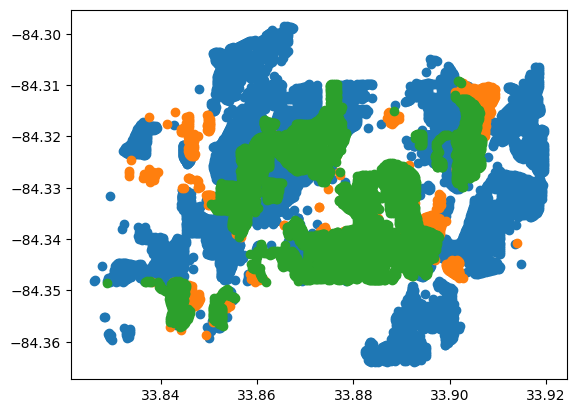

In [90]:
import re

def parse_providers(cell):
    """
    Convert a cell like 'Google Fiber(1) |AT&T(1) ' -> ['AT&T', 'Google Fiber']
    - Splits on '|'
    - Removes trailing counts like '(1)'
    - Strips whitespace
    - Normalizes duplicates
    - Returns [] for None/NaN/empty
    """
    if pd.isna(cell):
        return []

    # Split on '|'
    parts = [p.strip() for p in str(cell).split('|') if p.strip()]
    cleaned = []

    for p in parts:
        # Remove trailing count in parentheses, e.g., '(1)'
        p = re.sub(r'\(\d+\)\s*$', '', p).strip()
        if p:
            cleaned.append(p)

    return sorted(cleaned)

results_df = pd.DataFrame(results)
results_df.drop('uuid', axis=1, inplace = True)

results_df['bdc_fiberproviders'] = results_df['bdc_fiberproviders'].apply(parse_providers)

# Masks
att_mask = results_df['bdc_fiberproviders'].apply(lambda xs: ('AT&T' in xs) and (len(xs) == 1))
google_mask = results_df['bdc_fiberproviders'].apply(lambda xs: ('Google Fiber' in xs) and (len(xs) == 1))
att_and_google_mask = results_df['bdc_fiberproviders'].apply(lambda xs: (('Google Fiber' in xs) and ('AT&T' in xs) and (len(xs) == 2)))

# Subsets
att_only = results_df[att_mask]
google_only = results_df[google_mask]
att_and_google = results_df[att_and_google_mask]

plt.scatter(att_only['latitude'], att_only['longitude'])
plt.scatter(google_only['latitude'], google_only['longitude'])
plt.scatter(att_and_google['latitude'], att_and_google['longitude'])

plt.show()

In [101]:
from cqazapipytools import *

Brookhaven_tractFIPS = [
    '13089021101',
    '13089021103',
    '13089021104',
    '13089021219',
    '13089021220',
    '13089021221',
    '13089021222',
    '13089021405',
    '13089021410',
    '13089021411',
    '13089021412',
    '13089021415',
    '13089021416',
    '13089021417',
    '13089021418',
    '13089021419',
    '13089021420',
    '13089021421',
    '13089021607',
    '13121009409',
    '13121009410',
    '13121009607',
    '13121010115',
]

VINTAGE = '202406'
FIELDS = 'location_id,latitude,longitude,blockfips,bdc_fiber,bdc_fiberproviders'
CHUNK_SIZE = 1000

with cqazapipytools(API_KEY, cachepath='cache.db') as cp:
    tract_geojson = cp.apiAction(f'geosvc/libgetgeo/tiger/2020/tracts?id={Brookhaven_tractFIPS[0]}', 'GET')
    uuids = cp.collect(VINTAGE, tract_geojson)
    for fips in Brookhaven_tractFIPS[1:]:
        tract_geojson = cp.apiAction(f'geosvc/libgetgeo/tiger/2020/tracts?id={fips}', 'GET')
        uuids += cp.collect(VINTAGE, tract_geojson)

    # Call Fabric bulk api, retrieve only desired fields
    endpoint = f'fabric/{VINTAGE}/bulk/locations?field={FIELDS}'
    results = cp.bulkApiAction(endpoint, 'POST', uuids, maxsize=CHUNK_SIZE)

    # Show a quick sample
    print(f"Returned {len(results)} records")
    for r in results[:3]:
        print(r)

API request (1/0) to GET https://api.costquest.com/accountcontrol/listapis succeeded in 0.497s
API request (2/0) to CACHE https://api.costquest.com/geosvc/libgetgeo/tiger/2020/tracts?id=13089021101 succeeded in 0.011s
API request (3/0) to CACHE https://api.costquest.com/fabric/202406/collect2 succeeded in 0.001s
API request (4/0) to CACHE https://api.costquest.com/geosvc/libgetgeo/tiger/2020/tracts?id=13089021103 succeeded in 0.001s
API request (5/0) to CACHE https://api.costquest.com/fabric/202406/collect2 succeeded in 0.001s
API request (6/0) to CACHE https://api.costquest.com/geosvc/libgetgeo/tiger/2020/tracts?id=13089021104 succeeded in 0.001s
API request (7/0) to CACHE https://api.costquest.com/fabric/202406/collect2 succeeded in 0.001s
API request (8/0) to CACHE https://api.costquest.com/geosvc/libgetgeo/tiger/2020/tracts?id=13089021219 succeeded in 0.001s
API request (9/0) to CACHE https://api.costquest.com/fabric/202406/collect2 succeeded in 0.001s
API request (10/0) to CACHE h

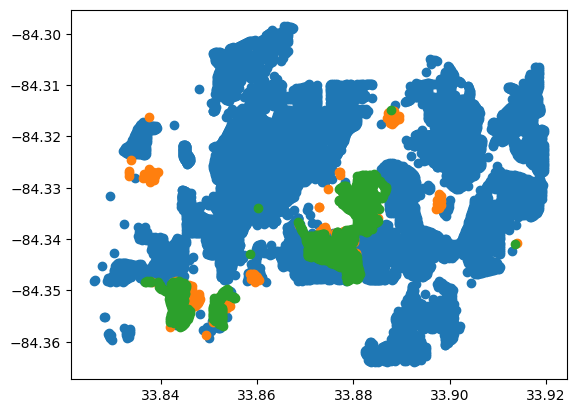

In [102]:
import re

def parse_providers(cell):
    """
    Convert a cell like 'Google Fiber(1) |AT&T(1) ' -> ['AT&T', 'Google Fiber']
    - Splits on '|'
    - Removes trailing counts like '(1)'
    - Strips whitespace
    - Normalizes duplicates
    - Returns [] for None/NaN/empty
    """
    if pd.isna(cell):
        return []

    # Split on '|'
    parts = [p.strip() for p in str(cell).split('|') if p.strip()]
    cleaned = []

    for p in parts:
        # Remove trailing count in parentheses, e.g., '(1)'
        p = re.sub(r'\(\d+\)\s*$', '', p).strip()
        if p:
            cleaned.append(p)

    return sorted(cleaned)

results_df = pd.DataFrame(results)
results_df.drop('uuid', axis=1, inplace = True)

results_df['bdc_fiberproviders'] = results_df['bdc_fiberproviders'].apply(parse_providers)

# Masks
att_mask = results_df['bdc_fiberproviders'].apply(lambda xs: ('AT&T' in xs) and (len(xs) == 1))
google_mask = results_df['bdc_fiberproviders'].apply(lambda xs: ('Google Fiber' in xs) and (len(xs) == 1))
att_and_google_mask = results_df['bdc_fiberproviders'].apply(lambda xs: (('Google Fiber' in xs) and ('AT&T' in xs) and (len(xs) == 2)))

# Subsets
att_only = results_df[att_mask]
google_only = results_df[google_mask]
att_and_google = results_df[att_and_google_mask]

plt.scatter(att_only['latitude'], att_only['longitude'])
plt.scatter(google_only['latitude'], google_only['longitude'])
plt.scatter(att_and_google['latitude'], att_and_google['longitude'])

plt.show()